After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

- Download the monthly natural gas price data.
- Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
- Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
- Your code should take a date as input and return a price estimate.

Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Understanding the Data

In [2]:
df = pd.read_csv('../Task 1 - Estimate gas prices/data/Nat_Gas.csv')

In [3]:
df['Dates'] = pd.to_datetime(df['Dates'])
df['month_year'] = df['Dates'].dt.strftime('%Y-%m')

df.head()

,Dates,Prices,month_year
0,2020-10-31,10.1,2020-10
1,2020-11-30,10.3,2020-11
2,2020-12-31,11.0,2020-12
3,2021-01-31,10.9,2021-01
4,2021-02-28,10.9,2021-02


In [4]:
df.tail()

,Dates,Prices,month_year
43,2024-05-31,11.4,2024-05
44,2024-06-30,11.5,2024-06
45,2024-07-31,11.6,2024-07
46,2024-08-31,11.5,2024-08
47,2024-09-30,11.8,2024-09


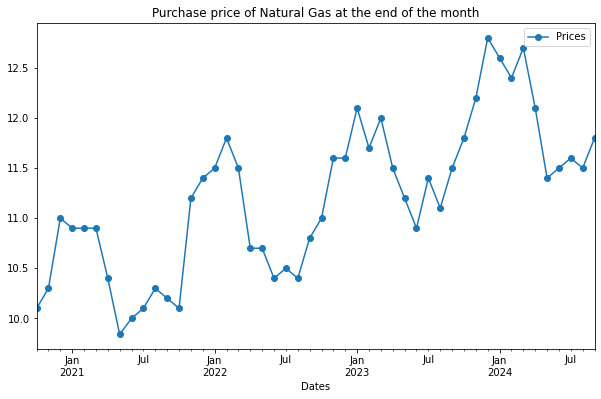

In [5]:
df.plot(kind='line', y='Prices', x='Dates', marker='o', title='Purchase price of Natural Gas at the end of the month', figsize=(10, 6));

## Season and Trends

Let's try to identify the data trend and if there is any seasonal pattern.

To do this, we will employ the 'statsmodels.tsa.seasonal' library, specifically its 'seasonal_decompose' module. This library is used for time series analysis and allows us to decompose a time series into its individual components, such as trend, seasonality, and residuals. The 'seasonal_decompose' function, in particular, helps us extract these components from the data, making it easier to identify trends and seasonal patterns in time series data."

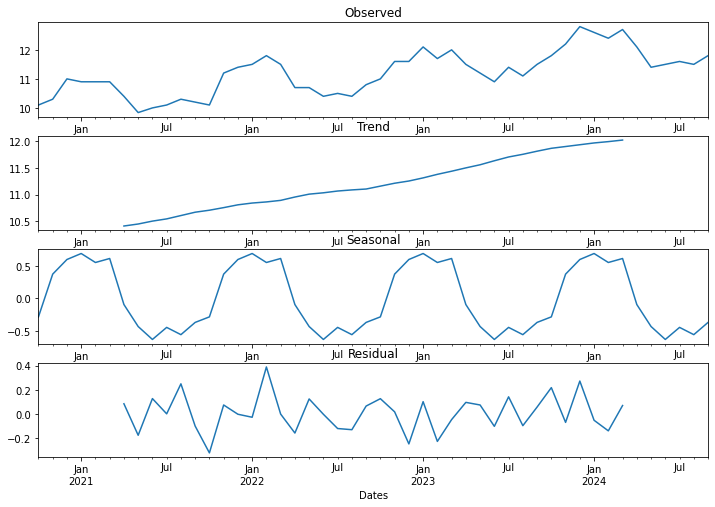

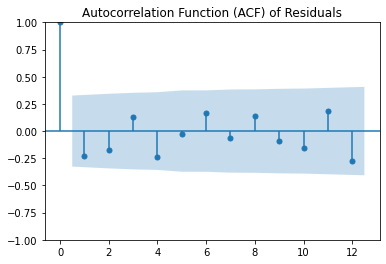

In [6]:
df = pd.read_csv('../Task 1 - Estimate gas prices/data/Nat_Gas.csv')
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

decomposition = seasonal_decompose(df['Prices'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
ax1.set_title('Observed')
ax2.set_title('Trend')
ax3.set_title('Seasonal')
ax4.set_title('Residual')

decomposition.observed.plot(ax=ax1)
decomposition.trend.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
decomposition.resid.plot(ax=ax4)

plot_acf(decomposition.resid.dropna(), lags=12) 
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()


#### Seasonal Decomposition Subplots:

1. **Observed Data (Top Subplot)**:
   - This subplot shows the original time series data. It represents the actual values of the variable you are analyzing (in this case, natural gas prices) over time.

2. **Trend Component (Second Subplot)**:
   - The trend component represents the underlying long-term trend or pattern in the data. It removes the short-term fluctuations and seasonality to reveal the overall direction of the data.

3. **Seasonal Component (Third Subplot)**:
   - The seasonal component represents the periodic or seasonal pattern in the data. It shows the recurring patterns that happen at specific intervals, such as daily, monthly, or yearly. In the context of natural gas prices, this could be the regular price fluctuations that occur seasonally, such as due to weather or demand patterns.

4. **Residual Component (Bottom Subplot)**:
   - The residual component represents the noise or randomness left in the data after removing the trend and seasonal components. It shows the irregular or unpredictable fluctuations in the data that are not accounted for by the trend and seasonality.

#### Autocorrelation Function (ACF) Plot:

- The Autocorrelation Function (ACF) plot is used to understand the correlation between a time series and its lagged values (previous time points). Each point on the plot represents the correlation between the time series at the current time step and the time series at a lagged time step (e.g., one month ago, two months ago, etc.).

- In the context of seasonal decomposition, the ACF plot of the residual component helps you identify whether there is any remaining pattern or seasonality in the residuals after the trend and seasonal components have been removed. Peaks or significant spikes in the ACF plot at certain lags indicate that there might be some recurring patterns or seasonality at those time intervals.

- By analyzing the ACF plot, you can identify the lags at which seasonality or repeating patterns occur, helping you understand and quantify the seasonality in your time series data.

In summary, the seasonal decomposition subplots help you visualize and break down your time series into its trend, seasonal, and residual components, while the ACF plot helps you identify any remaining patterns or seasonality in the residuals. These tools are useful for understanding and quantifying the underlying patterns in your data.


#### ACF (Autocorrelation Function) of Residual Component:

- The ACF (Autocorrelation Function) plot is a tool used in time series analysis to understand the correlation between a time series and its lagged values, which are the values at previous time points. 

- In the ACF plot, each point represents the correlation between the time series at the current time step and the time series at a lagged time step. For example, if you have monthly data, a lag of 1 represents the correlation between the time series at the current month and the time series one month ago.

- When analyzing the ACF plot of the residual component, the following observations can be made based on the values:

    - **Lag 0 (X=0)**:
      - A lag of 0 means comparing the time series with itself at the same time point. The ACF value at lag 0 is always 1 because any time series is perfectly correlated with itself.

    - **Positive Value at Lag 0**:
      - The positive value at lag 0 indicates a strong autocorrelation at the same time point, which is expected and is a result of the perfect correlation between the time series and itself.

    - **Values Between 0.20 and -0.25 at Other Lags**:
      - The ACF values between 0.20 and -0.25 at other lags (lags greater than 0) suggest there might be some weak autocorrelation at those lags, but it's not very strong. Values close to zero indicate a weaker correlation between the time series and its lagged values.

- In this case, it appears that there is not a strong autocorrelation in the residual component at lags other than 0. This suggests that after removing the trend and seasonal components from the time series data, the remaining variation is mostly random or not strongly correlated with its past values. This can be a good sign, as it implies that we have successfully removed most of the seasonality and trends from the data, leaving behind relatively uncorrelated residuals.


# Time Series Forecasting with SARIMA

In this task, we'll use a Seasonal Autoregressive Integrated Moving Average (SARIMA) model to forecast natural gas prices. SARIMA models are particularly well-suited for time series data with seasonality, which is common in natural gas price data due to factors like weather and demand patterns.


## Why SARIMA?

**SARIMA models** are a powerful choice for time series forecasting when dealing with data that exhibits recurring patterns or seasonality. These models take into account the autocorrelation of the data at different lags (previous time points), the trend in the data, and the seasonality that occurs at regular intervals. Here's why we're using SARIMA:

1. **Captures Seasonality**: SARIMA can capture the seasonal fluctuations that occur in natural gas prices, such as those driven by changes in weather conditions or demand during different times of the year.

2. **Handles Trends**: SARIMA accounts for underlying trends in the data, allowing us to make forecasts that reflect both short-term variations and long-term directional changes.

3. **Flexibility**: SARIMA models allow us to customize the orders of autoregressive (AR), differencing (I), and moving average (MA) components, as well as the seasonal orders, to match the characteristics of our specific dataset.

4. **Proven Effectiveness**: SARIMA has a proven track record in time series forecasting and is widely used in various industries for making accurate predictions.



## Performance Metrics

Now that we've made forecasts using the SARIMA model, it's essential to assess how well the model performed in predicting natural gas prices. We'll do this by considering several performance metrics that provide insights into the quality of our forecasts.

### Mean Absolute Error (MAE)

- The **Mean Absolute Error (MAE)** tells us, on average, how far off our predictions are from the actual values. It's a measure of the absolute magnitude of errors, with lower values indicating better accuracy. For example, if the MAE is 2.5, it means, on average, our predictions are off by $2.5 in either direction.

### Root Mean Squared Error (RMSE)

- The **Root Mean Squared Error (RMSE)** is another measure of prediction accuracy. It's similar to MAE but gives more weight to larger errors. RMSE provides a sense of the typical size of errors in our forecasts. A lower RMSE is better.

### Mean Absolute Percentage Error (MAPE)

- The **Mean Absolute Percentage Error (MAPE)** is a percentage-based metric that measures the relative size of errors. It's useful when we want to understand the accuracy of predictions relative to the scale of the data. Like MAE, lower MAPE values are desirable.

### Symmetric Mean Absolute Percentage Error (SMAPE)

- The **Symmetric Mean Absolute Percentage Error (SMAPE)** is another percentage-based metric that symmetrically measures the relative error. It's similar to MAPE but has a different formula. Like MAPE, lower SMAPE values are better.

### Forecast Bias

- Forecast bias tells us if our predictions tend to be consistently too high or too low. A bias close to zero indicates that, on average, our forecasts are unbiased.

### Forecast Accuracy

- Forecast accuracy measures the percentage of correct forecasts within a specified tolerance or prediction interval. It helps us assess how well our predictions align with the actual outcomes within a predefined range.

### AIC and BIC

- The **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)** are information criteria that balance model fit and complexity. Lower AIC and BIC values suggest a better model fit.

### Residual Analysis

- After making forecasts, it's crucial to analyze the residuals (the differences between our predictions and actual values). Residual analysis helps us identify any remaining patterns or autocorrelations in the residuals, which may indicate areas where the model can be improved.

In summary, by evaluating these performance metrics and conducting thorough residual analysis, we can gauge how well our SARIMA model performed in predicting natural gas prices and identify areas for potential model refinement.


## SARIMA

### First Run

#### Prediction

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


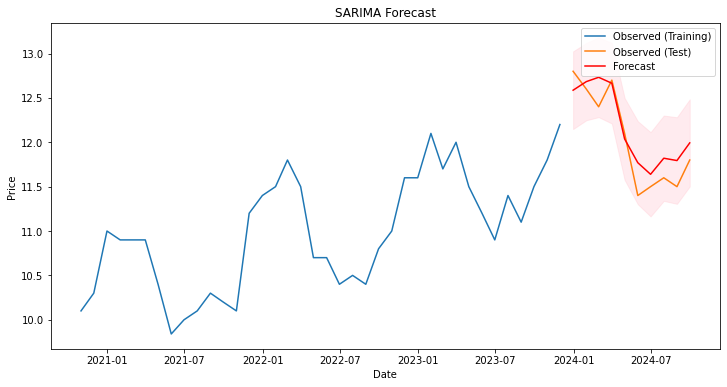

In [7]:
df = pd.read_csv('../Task 1 - Estimate gas prices/data/Nat_Gas.csv')
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

# Train-Test Split
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# Seasonal Decomposition (Optional)
# decomposition = seasonal_decompose(train_data['price'], model='additive')

# Model Selection
# Use ACF and PACF plots to determine SARIMA orders
# plot_acf(train_data['price'])
# plot_pacf(train_data['price'])

# Define SARIMA orders (p, d, q, P, D, Q, s)
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12

# Model Training
sarima_model = SARIMAX(train_data['Prices'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit()

# Model Evaluation
forecast = sarima_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Visualize Results
plt.figure(figsize=(12, 6),facecolor='white')
plt.plot(train_data.index, train_data['Prices'], label='Observed (Training)')
plt.plot(test_data.index, test_data['Prices'], label='Observed (Test)')
plt.plot(test_data.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show();


#### Performance

In [8]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['Prices'], forecast_mean)

# Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(test_data['Prices'], forecast_mean))

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data['Prices'] - forecast_mean) / test_data['Prices'])) * 100

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.mean(2 * np.abs(test_data['Prices'] - forecast_mean) / (np.abs(test_data['Prices']) + np.abs(forecast_mean)))

# Forecast Bias
bias = np.mean(forecast_mean - test_data['Prices'])

# Print or use the calculated metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
print(f"Forecast Bias: {bias:.2f}")

Mean Absolute Error (MAE): 0.19
Root Mean Squared Error (RMSE): 0.22
Mean Absolute Percentage Error (MAPE): 1.63%
Symmetric Mean Absolute Percentage Error (SMAPE): 1.62%
Forecast Bias: 0.13


In [9]:
test_data.tail()

,Prices
Dates,
2024-05-31,11.4
2024-06-30,11.5
2024-07-31,11.6
2024-08-31,11.5
2024-09-30,11.8


### Second Run

#### Prediction

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


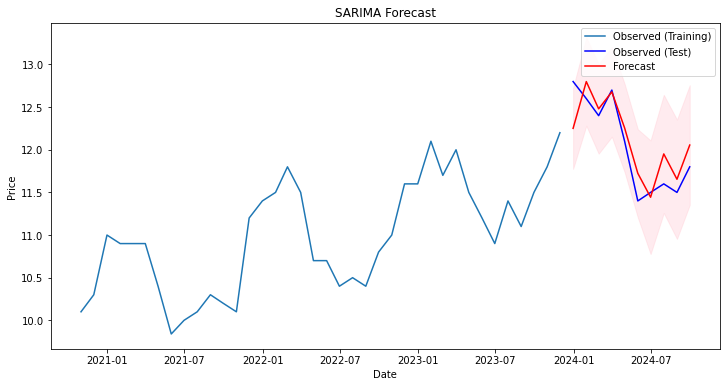

In [22]:
df = pd.read_csv('../Task 1 - Estimate gas prices/data/Nat_Gas.csv')
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

# Train-Test Split
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# Seasonal Decomposition (Optional)
# decomposition = seasonal_decompose(train_data['price'], model='additive')

# Model Selection
# Use ACF and PACF plots to determine SARIMA orders
# plot_acf(train_data['price'])
# plot_pacf(train_data['price'])

# Define SARIMA orders (p, d, q, P, D, Q, s)
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 6

# Model Training
sarima_model = SARIMAX(train_data['Prices'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit()

# Model Evaluation
forecast = sarima_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Visualize Results
plt.figure(figsize=(12, 6),facecolor='white')
plt.plot(train_data.index, train_data['Prices'], label='Observed (Training)')
plt.plot(test_data.index, test_data['Prices'], label='Observed (Test)', color='blue')
plt.plot(test_data.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show();


#### Performance

In [11]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['Prices'], forecast_mean)

# Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(test_data['Prices'], forecast_mean))

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data['Prices'] - forecast_mean) / test_data['Prices'])) * 100

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.mean(2 * np.abs(test_data['Prices'] - forecast_mean) / (np.abs(test_data['Prices']) + np.abs(forecast_mean)))

# Forecast Bias
bias = np.mean(forecast_mean - test_data['Prices'])

# Print or use the calculated metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
print(f"Forecast Bias: {bias:.2f}")

Mean Absolute Error (MAE): 0.21
Root Mean Squared Error (RMSE): 0.26
Mean Absolute Percentage Error (MAPE): 1.78%
Symmetric Mean Absolute Percentage Error (SMAPE): 1.78%
Forecast Bias: 0.09


In [12]:
test_data.tail()

,Prices
Dates,
2024-05-31,11.4
2024-06-30,11.5
2024-07-31,11.6
2024-08-31,11.5
2024-09-30,11.8


## SARIMA Forecast X Periods in the Future

In [13]:
df = pd.read_csv('../Task 1 - Estimate gas prices/data/Nat_Gas.csv')
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

# Train-Test Split
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# Fit the SARIMA model to your historical data
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12  # Adjust these orders as per your model selection
sarima_model = SARIMAX(df['Prices'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit()

# Define the number of future periods you want to forecast
forecast_periods = 12  # For example, to forecast the next 12 months

# Generate forecasts for future periods
forecast = sarima_fit.get_forecast(steps=forecast_periods)

# Access the forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a datetime index for the future forecasted periods
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=forecast_index)

# Print or use the forecasted values
print(forecast_df)

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


             Forecast
2024-10-31  11.987295
2024-11-30  12.610021
2024-12-31  12.925149
2025-01-31  13.064663
2025-02-28  13.012236
2025-03-31  13.043970
2025-04-30  12.439595
2025-05-31  12.121297
2025-06-30  11.987232
2025-07-31  12.211975
2025-08-31  12.131959
2025-09-30  12.378313


c:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


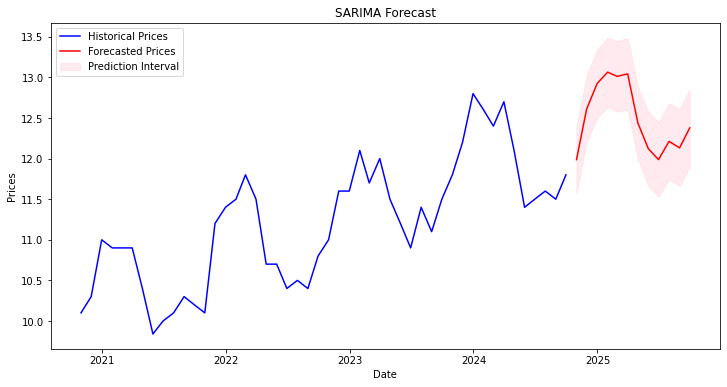

In [14]:

# Plot the observed historical data
plt.figure(figsize=(12, 6),facecolor='white')
plt.plot(df.index, df['Prices'], label='Historical Prices', color='blue')

# Plot the forecasted values
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Prices', color='red')

# Plot the prediction intervals as shaded areas
plt.fill_between(forecast_df.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Prediction Interval')

# Add labels and a legend
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()

# Show the plot
plt.show()

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Python310\lib\site-packages\statsmodels\tsa\st

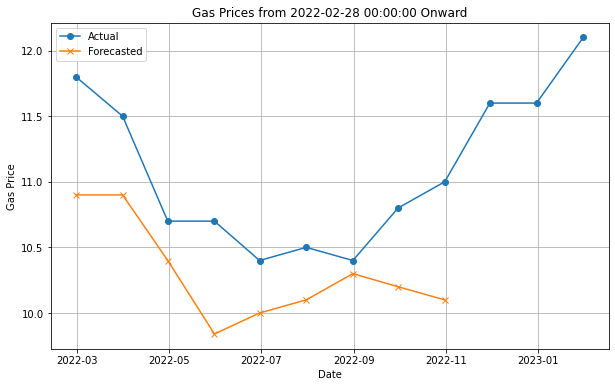

Predict price at 2022-02-28: $10.90


In [15]:
df = pd.read_csv('../Task 1 - Estimate gas prices/data/Nat_Gas.csv')
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

def estimate_gas_prices(input_date):
    # Check if the input_date is within the range of the DataFrame
    if input_date in df.index:
        # Cut the data up to one period before the input date
        df_subset = df[df.index <= input_date]
        
        # Define SARIMA orders (adjust as needed)
        p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12
        
        # Train-test split
        train_size = int(0.8 * len(df_subset))
        train_data = df_subset[:train_size]
        test_data = df_subset[train_size:]
        
        # Fit the SARIMA model to the train data
        sarima_model = SARIMAX(train_data['Prices'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        sarima_fit = sarima_model.fit()
        
        # Define the number of future periods you want to forecast
        forecast_periods = 12
        
        # Generate forecasts for future periods
        forecast = sarima_fit.get_forecast(steps=forecast_periods)
        
        # Access the forecasted values
        forecast_mean = forecast.predicted_mean
        
        # Create a datetime index for the future forecasted periods
        forecast_index = pd.date_range(start=input_date, periods=forecast_periods, freq='M')
        
        # Create a DataFrame for the forecasted values and actual prices
        forecast_df = pd.DataFrame({'Price': df[input_date:forecast_index[-1]]['Prices'],
                                     'Forecast': forecast_mean}, index=forecast_index)
        
        return forecast_df

    # If the input_date is outside the range, perform a full forecast using SARIMA
    else:
        # Fit the SARIMA model to your historical data
        p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12  # Adjust these orders as per your model selection
        sarima_model = SARIMAX(df['Prices'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        sarima_fit = sarima_model.fit()

        # Define the number of future periods you want to forecast
        forecast_periods = 12  # For example, to forecast the next 12 months

        # Generate forecasts for future periods
        forecast = sarima_fit.get_forecast(steps=forecast_periods)

        # Access the forecasted values
        forecast_mean = forecast.predicted_mean
        
        # Create a datetime index for the future forecasted periods
        forecast_index = pd.date_range(start=input_date, periods=forecast_periods, freq='M')

        # Create a DataFrame for the forecasted values
        forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=forecast_index)

        return forecast_df

# Function to plot the gas prices starting from the input date, including actual and predicted values
def plot_gas_prices(input_date, gas_prices):
    plt.figure(figsize=(10, 6),facecolor='white')
    
    if 'Price' in gas_prices.columns:
        plt.plot(gas_prices.index, gas_prices['Price'], marker='o', linestyle='-', label='Actual')
    
    if 'Forecast' in gas_prices.columns:
        plt.plot(gas_prices.index, gas_prices['Forecast'], marker='x', linestyle='-', label='Forecasted')
    
    plt.title(f"Gas Prices from {input_date} Onward")
    plt.xlabel("Date")
    plt.ylabel("Gas Price")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
input_date = pd.to_datetime("2022-02-28")  # Replace with any desired date
gas_prices = estimate_gas_prices(input_date)
plot_gas_prices(input_date, gas_prices)
print(f'Predict price at {input_date.strftime("%Y-%m-%d")}: ${gas_prices["Forecast"][0]:.2f}')